# Churn Model Optimization

# Data Dictionary
customers
- **ID_CLIENT** Identifiant du client
- **DATE_ENTREE** Date d'entrée du client
- **NOM** Nom du client
- **PAYS** Pays de naissance
- **SEXE** Sexe
- **AGE** Age du client
- **MEMBRE_ACTIF** Variable booléenne indiquant si le client est actif ou non.
  
  
indicators
- **ID_CLIENT** Identifiant du client
- **BALANCE** Balance du client
- **NB_PRODUITS** Nombre de produits détenus
- **CARTE_CREDIT** Variable booléenne indiquant si le client détient une carte de crédit
- **SALAIRE** Salaire estimé du client
- **SCORE_CREDIT** Score de crédit
- **CHURN** Variable cible indiquant si le client a quitté la banque


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from sklearn.metrics import accuracy_score, recall_score, f1_score, fbeta_score, precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

from mlxtend.classifier import StackingCVClassifier

from xgboost import XGBClassifier


import src.settings.settings as stg

from src.infrastructure.raw_bank_data import RawBankData
from src.infrastructure.technical_cleaning import BooleanEncoder, CategoricalTypeTransformer, DateTransformer
from src.domain.domain_cleaning import FrequencyEncoder, CustomOneHotEncoder, AberrantAgeImputer,\
                                       AberrantNbProduitsImputer, CreditScoreImputer, SalaryImputer,\
                                       BalanceImputer
from src.domain.feature_engineering import SeniorityCreator, CreditScoreAgeRatioCreator, BalanceWageRatioCreator,\
                                           CreditScoreByNProductsCreator, FeatureDropper, AgeClassCreator

In [2]:
CUSTOMERS_ID_CLIENT = 'ID_CLIENT'
DATE_ENTREE = 'DATE_ENTREE'
NOM = 'NOM'
PAYS = 'PAYS'
SEXE = 'SEXE'
AGE = 'AGE'
MEMBRE_ACTIF = 'MEMBRE_ACTIF'

INDICATORS_ID_CLIENT = 'ID_CLIENT'
BALANCE = 'BALANCE'
NB_PRODUITS = 'NB_PRODUITS'
CARTE_CREDIT = 'CARTE_CREDIT'
SALAIRE = 'SALAIRE'
SCORE_CREDIT = 'SCORE_CREDIT'
CHURN = 'CHURN'

ANCIENNETE = 'ANCIENNETE'
CATEGORIE_AGE = 'CATEGORIE_AGE'
RATIO_SCORE_CREDIT_AGE = 'RATIO_SCORE_CREDIT_AGE'
RATIO_BALANCE_SALAIRE = 'RATIO_BALANCE_SALAIRE'
RATIO_SCORE_CREDIT_NB_PRODUITS = 'RATIO_SCORE_CREDIT_NB_PRODUITS'

In [3]:
def find_threshold_f2(y_val, y_proba):
    """Find threshold giving the best f2 score. Arguments must have the same length.
    
    Arguments
    ---------
    y_proba: pandas.Series
    y_val: pandas.Series
    
    Returns
    -------
    best_threshold: float
    best_f2: threshold
    """
    threshold = 0
    y_pred = (y_proba >= threshold).astype(bool)
    best_threshold = 0
    best_f2 = 0
    while threshold < 1:
        f2 = fbeta_score(y_val, y_pred, beta=2)
        threshold += 0.001
        y_pred = (y_proba >= threshold).astype(bool)
        if f2 > best_f2:
            best_f2 = f2
            best_threshold = threshold
    return best_threshold, best_f2

In [4]:
def score_func(y_proba, y_val):
    """Docstring"""
    _, f2 = find_threshold_f2(y_proba, y_val)
    return f2

f2_score = make_scorer(score_func, greater_is_better=True,needs_proba=True)

In [5]:
def plot_features_importance(data, importances, n_feat):
    """Plot the features importance barplot.

    Arguments
    ----------
    data : pd.DataFrame
        data containing colnames used in the model.

    importances : np.ndarray
        list of feature importances

    n_feat : int
        number of features to plot

    """
    indices = np.argsort(importances)[::-1]
    features = data.columns

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices][:n_feat],
                y=features[indices][:n_feat], palette='Blues_r')
    plt.title("Top {} Features Importance".format(n_feat))
    return plt.show()

# PIPELINE

In [6]:
bank_dataset = RawBankData()
X = bank_dataset.features
y = bank_dataset.target
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9950 entries, 0 to 9949
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID_CLIENT     9950 non-null   object 
 1   DATE_ENTREE   9950 non-null   object 
 2   PAYS          9950 non-null   object 
 3   SEXE          9950 non-null   object 
 4   AGE           9950 non-null   int64  
 5   MEMBRE_ACTIF  9950 non-null   object 
 6   BALANCE       9932 non-null   float64
 7   NB_PRODUITS   9950 non-null   int64  
 8   CARTE_CREDIT  9950 non-null   object 
 9   SALAIRE       9721 non-null   float64
 10  SCORE_CREDIT  9391 non-null   float64
dtypes: float64(3), int64(2), object(6)
memory usage: 932.8+ KB


In [7]:
bank_dataset = RawBankData()
X = bank_dataset.features
y = bank_dataset.target

#Pipeline building
pipeline = Pipeline(steps=[
    ("DateTransformer", DateTransformer(**stg.PARAMS_DATE_TRANSFORMER)),
    ("CategoricalTypeTransformer", CategoricalTypeTransformer(**stg.PARAMS_CATEGORICAL_TYPE_TRANSFORMER)),
    ("BooleanEncoder", BooleanEncoder(**stg.PARAMS_BOOLEAN_ENCODER)),
    ("OneHotEncoder", CustomOneHotEncoder(**stg.PARAMS_ONE_HOT_ENCODER)),
    ("AberrantAgeImputer", AberrantAgeImputer()),
    ("AberrantNbProduitsImputer", AberrantNbProduitsImputer()),
    ("CreditScoreImputer", CreditScoreImputer(**stg.PARAMS_CREDIT_SCORE_IMPUTER)),
    ("AgeClassCreator", AgeClassCreator(stg.CATEGORIE_AGE)),
    ("SeniorityCreator", SeniorityCreator(**stg.PARAMS_SENIORITY_CREATOR)),
    ("SalaryImputer", SalaryImputer(**stg.PARAMS_SALARY_IMPUTER)),
    ("BalanceImputer", BalanceImputer()),
    ("CreditScoreAgeRatioCreator", CreditScoreAgeRatioCreator(stg.RATIO_SCORE_CREDIT_AGE)),
    ("CreditScoreByNProductsCreator", CreditScoreByNProductsCreator(stg.RATIO_SCORE_CREDIT_NB_PRODUITS)),
    ("FeatureDropper", FeatureDropper(**stg.PARAMS_FEATURE_DROPPER))
])

clients = pipeline.fit_transform(X, y)

In [8]:
clients

SEXE  AGE MEMBRE_ACTIF    BALANCE  NB_PRODUITS CARTE_CREDIT    SALAIRE  \
0       0   40            0       0.00            2          Yes   88947.56   
1       1   29            0       0.00            2          Yes       0.00   
2       0   47            1  118079.47            4          Yes  143007.49   
3       0   36            0  106702.94            2           No  198313.69   
4       0   36            1       0.00            2          Yes    8742.91   
...   ...  ...          ...        ...          ...          ...        ...   
9945    1   28            1  124540.28            1           No  188850.89   
9946    1   61            0       0.00            1          Yes   61108.56   
9947    1   22            0       0.00            1          Yes   22303.17   
9948    1   31            1       0.00            2          Yes  136610.02   
9949    0   29            1  127414.55            1          Yes  134459.12   

      SCORE_CREDIT  PAYS_Allemagne  PAYS_Espagne  PAYS_France CATEGORIE_AGE  \
0            677.0               0             1            0             2   
1            350.0               0             1            0             1   
2            773.0               1             0            0             3   
3            607.0               1             0            0             2   
4            628.0               0             0            1             2   
...            ...             ...           ...          ...           ...   
9945         755.0               0             0            1             1   
9946         589.0               0             0            1             3   
9947         759.0               0             0            1             1   
9948         689.0               0             1            0             1   
9949         802.0               0             0            1             1   

      ANCIENNETE  RATIO_SCORE_CREDIT_AGE  RATIO_SCORE_CREDIT_NB_PRODUITS  
0           1978                   16.92                          338.50  
1           2223                   12.07                          175.00  
2            882                   16.45                          193.25  
3           3745                   16.86                          303.50  
4           1247                   17.44                          314.00  
...          ...                     ...                             ...  
9945        2708                   26.96                          755.00  
9946         397                    9.66                          589.00  
9947        1888                   34.50                          759.00  
9948        1582                   22.23                          344.50  
9949        3349                   27.66                          802.00  

[9950 rows x 15 columns]

In [29]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9950 entries, 0 to 9949
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   SEXE                            9950 non-null   category
 1   AGE                             9950 non-null   int64   
 2   MEMBRE_ACTIF                    9950 non-null   category
 3   BALANCE                         9950 non-null   float64 
 4   NB_PRODUITS                     9950 non-null   int64   
 5   CARTE_CREDIT                    9950 non-null   category
 6   SALAIRE                         9950 non-null   float64 
 7   SCORE_CREDIT                    9950 non-null   float64 
 8   PAYS_Allemagne                  9950 non-null   int64   
 9   PAYS_Espagne                    9950 non-null   int64   
 10  PAYS_France                     9950 non-null   int64   
 11  CATEGORIE_AGE                   9950 non-null   category
 12  ANCIENNETE          

In [145]:
from pandas_profiling import ProfileReport

profile2 = ProfileReport(clients, title="Pandas Profiling Report After Feature Engineering")
profile2.to_file('profile2.html')

# PCA

In [12]:
#Variance
variance = clients.var()
variance

AGE                               1.104295e+02
BALANCE                           3.890035e+09
NB_PRODUITS                       3.383406e-01
SALAIRE                           3.461532e+09
SCORE_CREDIT                      1.359431e+04
PAYS_Allemagne                    1.878451e-01
PAYS_Espagne                      1.865856e-01
PAYS_France                       2.500237e-01
ANCIENNETE                        1.117059e+06
RATIO_SCORE_CREDIT_AGE            3.096542e+01
RATIO_SCORE_CREDIT_NB_PRODUITS    3.491589e+04
dtype: float64

In [13]:
#Dimension Reduction
scaler = StandardScaler()
clients_scaled = scaler.fit_transform(clients)

pca = PCA(0.95)

clients_pca = pca.fit_transform(clients_scaled)

In [14]:
#Analyse PCA
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.17702541 0.14716157 0.11492047 0.09786868 0.08110046 0.06922241
 0.06800809 0.06636657 0.06405275 0.06217925 0.03828579]


Conclusion :  11 features hold 95% of the information !

# MODELS

In [94]:
#Data Import
bank_dataset = RawBankData()
X = bank_dataset.features
y = bank_dataset.target

In [95]:
# Dev / Test split : for testing final model only !!
X_dev, X_test, y_dev, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=26)

In [96]:
# Train / Val split : for training and tuning hyperparameters
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, stratify=y_dev, test_size=0.2, random_state=248)

In [97]:
#Vérification
print("X", X.shape)
print("X_dev", X_dev.shape)
print("X_test", X_test.shape)
print("X_train", X_train.shape)
print("X_val", X_val.shape)

X (9950, 11)
X_dev (7960, 11)
X_test (1990, 11)
X_train (6368, 11)
X_val (1592, 11)


In [98]:
#Preprocessor Pipeline
preprocessor = Pipeline(steps=[
    ("DateTransformer", DateTransformer(**stg.PARAMS_DATE_TRANSFORMER)),
    ("CategoricalTypeTransformer", CategoricalTypeTransformer(**stg.PARAMS_CATEGORICAL_TYPE_TRANSFORMER)),
    ("BooleanEncoder", BooleanEncoder([SEXE, MEMBRE_ACTIF])),
    ("FrequencyEncoder", FrequencyEncoder([PAYS, CARTE_CREDIT])),
    ("AberrantAgeImputer", AberrantAgeImputer()),
    ("AberrantNbProduitsImputer", AberrantNbProduitsImputer()),
    ("CreditScoreImputer", CreditScoreImputer(**stg.PARAMS_CREDIT_SCORE_IMPUTER)),
    ("SalaryImputer", SalaryImputer(**stg.PARAMS_SALARY_IMPUTER)),
    ("BalanceImputer", BalanceImputer()),
    ("SeniorityCreator", SeniorityCreator(**stg.PARAMS_SENIORITY_CREATOR)),
    ("CreditScoreAgeRatioCreator", CreditScoreAgeRatioCreator(stg.RATIO_SCORE_CREDIT_AGE)),
    ("CreditScoreByNProductsCreator", CreditScoreByNProductsCreator(stg.RATIO_SCORE_CREDIT_NB_PRODUITS)),
    ("FeatureDropper", FeatureDropper(**stg.PARAMS_FEATURE_DROPPER))
])


In [99]:
#Test
X_processed = preprocessor.fit_transform(X, y)
X_processed.head()

PAYS SEXE  AGE MEMBRE_ACTIF    BALANCE  NB_PRODUITS CARTE_CREDIT  \
0  0.248141    0   40            0       0.00            2     0.705126   
1  0.248141    1   29            0       0.00            2     0.705126   
2  0.250653    0   47            1  118079.47            4     0.705126   
3  0.250653    0   36            0  106702.94            2     0.294874   
4  0.501206    0   36            1       0.00            2     0.705126   

     SALAIRE  SCORE_CREDIT  ANCIENNETE  RATIO_SCORE_CREDIT_AGE  \
0   88947.56         677.0        1978                   16.92   
1       0.00         350.0        2223                   12.07   
2  143007.49         773.0         882                   16.45   
3  198313.69         607.0        3745                   16.86   
4    8742.91         628.0        1247                   17.44   

   RATIO_SCORE_CREDIT_NB_PRODUITS  
0                          338.50  
1                          175.00  
2                          193.25  
3                          303.50  
4                          314.00

## 1. Logistic Regression

In [243]:
#Bayesian optimization. Takes up to 5-10 minutes, change n_calls to 10 and cv to 3 to speed up the process.

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

space  = [Categorical([0, 350], name='preprocessor__CreditScoreImputer__value'), 
          Real(10**-4, 10**3, "log-uniform", name='classifier__C')]

@use_named_args(space)
def objective(**params):
    model.set_params(**params)

    return -np.mean(cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, 
                                    scoring=f2_score))

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0, verbose=True)

print("Best score=%.4f" % -res_gp.fun)
print("""Best parameters:
- CreditScoreImputer=%d
- C=%.6f""" % (res_gp.x[0], res_gp.x[1]))

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.4804
Function value obtained: -0.6559
Current minimum: -0.6559
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.0457
Function value obtained: -0.6559
Current minimum: -0.6559
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.6539
Function value obtained: -0.6610
Current minimum: -0.6610
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.6267
Function value obtained: -0.6330
Current minimum: -0.6610
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 5.8678
Function value obtained: -0.6596
Current minimum: -0.6610
Iteration No: 6 started.

In [100]:
# Model with parameters coming from bayesian search

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced',
                                      C=0.057210))
])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('DateTransformer',
                                  DateTransformer(date_format='%Y-%m-%d '
                                                              '%H:%M:%S')),
                                 ('CategoricalTypeTransformer',
                                  CategoricalTypeTransformer(columns=['PAYS',
                                                                      'SEXE',
                                                                      'MEMBRE_ACTIF',
                                                                      'CARTE_CREDIT'])),
                                 ('BooleanEncoder',
                                  BooleanEncoder(columns=['SEXE',
                                                          'MEMBRE_ACTIF'])),
                                 ('FrequencyEncoder',
                                  FrequencyEncoder(columns=['PAYS'...
                                 ('CreditScoreAgeR

In [101]:
# Predict
y_proba = model.predict_proba(X_val)[:,1]
threshold,_ = find_threshold_f2(y_val, y_proba)

y_pred = (y_proba >= threshold).astype(bool)

In [102]:
#Sauvegarde dans un dictionnaire
lr = {'model':model,
      'y_pred':y_pred,
      'y_proba':y_proba,
      'score':accuracy_score(y_val, y_pred),
      'recall':recall_score(y_val, y_pred),
      'ap':average_precision_score(y_val, y_proba),
      'fbeta_score':fbeta_score(y_val, y_pred, beta=2),
      'threshold': threshold
     }

In [103]:
#Score
print("model accuracy: %.2f" % accuracy_score(y_val, y_pred))
print("model recall: %.2f" % recall_score(y_val, y_pred))
print("model fbeta: %.2f" % fbeta_score(y_val, y_pred, beta=2))


print("\nPrecision-Recall-Fscore-Support")
print(precision_recall_fscore_support(y_val, y_pred, average='weighted'))

print("\nConfusion Matrix")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report")
print(classification_report(y_val, y_pred,
                            labels=[0,1],
                            target_names=['retain', 'churn']))

print("\nAverage Precision Score")
print(average_precision_score(y_val, y_proba))

model accuracy: 0.66
model recall: 0.83
model fbeta: 0.65

Precision-Recall-Fscore-Support
(0.8160229591270437, 0.6576633165829145, 0.6909757201469713, None)

Confusion Matrix
[[778 490]
 [ 55 269]]

Classification Report
              precision    recall  f1-score   support

      retain       0.93      0.61      0.74      1268
       churn       0.35      0.83      0.50       324

    accuracy                           0.66      1592
   macro avg       0.64      0.72      0.62      1592
weighted avg       0.82      0.66      0.69      1592


Average Precision Score
0.576502715991807


## 2. Naive Bayes

## 3. Decision Tree

In [104]:
#Model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(class_weight='balanced'))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('DateTransformer',
                                  DateTransformer(date_format='%Y-%m-%d '
                                                              '%H:%M:%S')),
                                 ('CategoricalTypeTransformer',
                                  CategoricalTypeTransformer(columns=['PAYS',
                                                                      'SEXE',
                                                                      'MEMBRE_ACTIF',
                                                                      'CARTE_CREDIT'])),
                                 ('BooleanEncoder',
                                  BooleanEncoder(columns=['SEXE',
                                                          'MEMBRE_ACTIF'])),
                                 ('FrequencyEncoder',
                                  FrequencyEncoder(columns=['PAYS'...
                                 ('CreditScoreAgeR

In [105]:
# Predict
y_proba = model.predict_proba(X_val)[:,1]
threshold,_ = find_threshold_f2(y_val, y_proba)

y_pred = (y_proba >= threshold).astype(bool)

In [106]:
#Sauvegarde dans un dictionnaire
dt = {'model':model,
      'y_pred':y_pred,
      'y_score':y_proba,
      'score':model.score(X_val, y_val),
      'recall':recall_score(y_val, y_pred),
      'ap':average_precision_score(y_val, y_proba),
      'fbeta_score':fbeta_score(y_val, y_pred, beta=2),
      'threshold': threshold
     }

In [107]:
#Score
print("model accuracy: %.2f" % accuracy_score(y_val, y_pred))
print("model recall: %.2f" % recall_score(y_val, y_pred))
print("model fbeta: %.2f" % fbeta_score(y_val, y_pred, beta=2))


print("\nPrecision-Recall-Fscore-Support")
print(precision_recall_fscore_support(y_val, y_pred, average='weighted'))

print("\nConfusion Matrix")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report")
print(classification_report(y_val, y_pred,
                            labels=[0,1],
                            target_names=['retain', 'churn']))

print("\nAverage Precision Score")
print(average_precision_score(y_val, y_proba))

model accuracy: 0.80
model recall: 0.45
model fbeta: 0.46

Precision-Recall-Fscore-Support
(0.7883063144115866, 0.7958542713567839, 0.7916883642547917, None)

Confusion Matrix
[[1122  146]
 [ 179  145]]

Classification Report
              precision    recall  f1-score   support

      retain       0.86      0.88      0.87      1268
       churn       0.50      0.45      0.47       324

    accuracy                           0.80      1592
   macro avg       0.68      0.67      0.67      1592
weighted avg       0.79      0.80      0.79      1592


Average Precision Score
0.3354336646535038


## 4. Random Forest

### First attempt without optimization of parameters

In [108]:
#Model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced'))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('DateTransformer',
                                  DateTransformer(date_format='%Y-%m-%d '
                                                              '%H:%M:%S')),
                                 ('CategoricalTypeTransformer',
                                  CategoricalTypeTransformer(columns=['PAYS',
                                                                      'SEXE',
                                                                      'MEMBRE_ACTIF',
                                                                      'CARTE_CREDIT'])),
                                 ('BooleanEncoder',
                                  BooleanEncoder(columns=['SEXE',
                                                          'MEMBRE_ACTIF'])),
                                 ('FrequencyEncoder',
                                  FrequencyEncoder(columns=['PAYS'...
                                 ('CreditScoreAgeR

In [109]:
# Predict
y_proba = model.predict_proba(X_val)[:,1]
threshold,_ = find_threshold_f2(y_val, y_proba)

y_pred = (y_proba >= threshold).astype(bool)

In [110]:
#Saving in dictionary
rf = {'model':model,
      'y_pred':y_pred,
      'y_score':y_proba,
      'score':model.score(X_val, y_val),
      'recall':recall_score(y_val, y_pred),
      'ap':average_precision_score(y_val, y_proba),
      'fbeta_score':fbeta_score(y_val, y_pred, beta=2),
      'threshold': threshold
     }

In [111]:
#Score
print("model accuracy: %.2f" % accuracy_score(y_val, y_pred))
print("model recall: %.2f" % recall_score(y_val, y_pred))
print("model fbeta: %.2f" % fbeta_score(y_val, y_pred, beta=2))


print("\nPrecision-Recall-Fscore-Support")
print(precision_recall_fscore_support(y_val, y_pred, average='weighted'))

print("\nConfusion Matrix")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report")
print(classification_report(y_val, y_pred,
                            labels=[0,1],
                            target_names=['retain', 'churn']))

print("\nAverage Precision Score")
print(average_precision_score(y_val, y_proba))

model accuracy: 0.72
model recall: 0.85
model fbeta: 0.70

Precision-Recall-Fscore-Support
(0.8387149251137282, 0.7248743718592965, 0.7509153697515698, None)

Confusion Matrix
[[879 389]
 [ 49 275]]

Classification Report
              precision    recall  f1-score   support

      retain       0.95      0.69      0.80      1268
       churn       0.41      0.85      0.56       324

    accuracy                           0.72      1592
   macro avg       0.68      0.77      0.68      1592
weighted avg       0.84      0.72      0.75      1592


Average Precision Score
0.6829529437846522


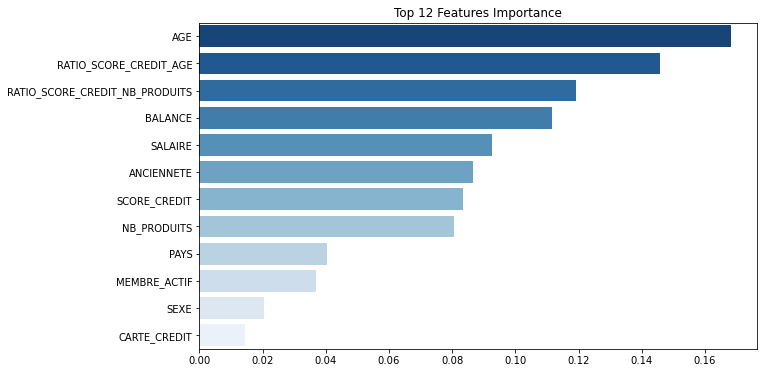

In [48]:
plot_features_importance(X_processed, importances=model['classifier'].feature_importances_, n_feat=12)

### Bayesian optimisation

In [227]:
# Takes up to 30 minutes, change n_calls to 10 and cv to 3 to speed up the process.
# May crash because of columns with too large values. Apply scaler if it does.

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced'))
])

space  = [Categorical([0, 350], name='preprocessor__CreditScoreImputer__value'),
          Integer(3, 12, name='classifier__max_depth'),
          Integer(10, 1500, name='classifier__n_estimators'),
          Integer(2, 15, name='classifier__min_samples_split'),
          Integer(1, 10, name='classifier__min_samples_leaf'),
          Categorical(['balanced', 'balanced_subsample'], name='classifier__class_weight'),
          Categorical(['entropy', 'gini'], name='classifier__criterion')]

@use_named_args(space)
def objective(**params):
    model.set_params(**params)

    return -np.mean(cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, 
                                    scoring=f2_score))

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0, verbose=True)

print("Best score=%.4f" % -res_gp.fun)
print("""Best parameters:
- CreditScoreImputer.value=%d
- max_depth=%d
- n_estimators=%d
- min_samples_split=%d
- min_samples_leaf=%d
- class_weight=%s
- criterion=%s""" % (res_gp.x[0], res_gp.x[1], res_gp.x[2], res_gp.x[3], res_gp.x[4], res_gp.x[5], res_gp.x[6]))

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 50.3542
Function value obtained: -0.7009
Current minimum: -0.7009
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 15.2598
Function value obtained: -0.6915
Current minimum: -0.7009
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 20.8488
Function value obtained: -0.7014
Current minimum: -0.7014
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 29.0542
Function value obtained: -0.7018
Current minimum: -0.7018
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 10.6924
Function value obtained: -0.7010
Current minimum: -0.7018
Iteration No: 6 star

In [172]:
# Train model with parameters found with bayesian search.

prepro = Pipeline(steps=[
    ("DateTransformer", DateTransformer(**stg.PARAMS_DATE_TRANSFORMER)),
    ("CategoricalTypeTransformer", CategoricalTypeTransformer(**stg.PARAMS_CATEGORICAL_TYPE_TRANSFORMER)),
    ("BooleanEncoder", BooleanEncoder([SEXE, MEMBRE_ACTIF])),
    ("FrequencyEncoder", FrequencyEncoder([PAYS, CARTE_CREDIT])),
    ("AberrantAgeImputer", AberrantAgeImputer()),
    ("AberrantNbProduitsImputer", AberrantNbProduitsImputer()),
    ("CreditScoreImputer", CreditScoreImputer(0)),
    ("SalaryImputer", SalaryImputer(**stg.PARAMS_SALARY_IMPUTER)),
    ("BalanceImputer", BalanceImputer()),
    ("SeniorityCreator", SeniorityCreator(**stg.PARAMS_SENIORITY_CREATOR)),
    ("CreditScoreAgeRatioCreator", CreditScoreAgeRatioCreator(stg.RATIO_SCORE_CREDIT_AGE)),
    ("CreditScoreByNProductsCreator", CreditScoreByNProductsCreator(stg.RATIO_SCORE_CREDIT_NB_PRODUITS)),
    ("FeatureDropper", FeatureDropper(**stg.PARAMS_FEATURE_DROPPER))
])

model = Pipeline(steps=[
    ('prepro', prepro),
    ('classifier', RandomForestClassifier(max_depth=8,
                                          n_estimators=932,
                                          min_samples_split=6,
                                          min_samples_leaf=1,
                                          class_weight='balanced_subsample',
                                          criterion='entropy',
                                          random_state=40))
])

model.fit(X_train, y_train)

Pipeline(steps=[('prepro',
                 Pipeline(steps=[('DateTransformer',
                                  DateTransformer(date_format='%Y-%m-%d '
                                                              '%H:%M:%S')),
                                 ('CategoricalTypeTransformer',
                                  CategoricalTypeTransformer(columns=['PAYS',
                                                                      'SEXE',
                                                                      'MEMBRE_ACTIF',
                                                                      'CARTE_CREDIT'])),
                                 ('BooleanEncoder',
                                  BooleanEncoder(columns=['SEXE',
                                                          'MEMBRE_ACTIF'])),
                                 ('FrequencyEncoder',
                                  FrequencyEncoder(columns=['PAYS',
                                                          

In [173]:
# Predict
y_proba = model.predict_proba(X_val)[:,1]
threshold,_ = find_threshold_f2(y_val, y_proba)

y_pred = (y_proba >= threshold).astype(bool)
threshold

0.33500000000000024

In [174]:
#Saving in dictionary
rf2 = {'model':model,
      'y_pred':y_pred,
      'y_score':y_proba,
      'score':model.score(X_val, y_val),
      'recall':recall_score(y_val, y_pred),
      'ap':average_precision_score(y_val, y_proba),
      'fbeta_score':fbeta_score(y_val, y_pred, beta=2),
      'threshold': threshold
     }

In [175]:
#Score
print("model accuracy: %.3f" % accuracy_score(y_val, y_pred))
print("model recall: %.3f" % recall_score(y_val, y_pred))
print("model fbeta: %.3f" % fbeta_score(y_val, y_pred, beta=2))


print("\nPrecision-Recall-Fscore-Support")
print(precision_recall_fscore_support(y_val, y_pred, average='weighted'))

print("\nConfusion Matrix")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report")
print(classification_report(y_val, y_pred,
                            labels=[0,1],
                            target_names=['retain', 'churn']))

print("\nAverage Precision Score")
print(average_precision_score(y_val, y_proba))

model accuracy: 0.712
model recall: 0.883
model fbeta: 0.714

Precision-Recall-Fscore-Support
(0.8446113569951421, 0.7116834170854272, 0.7395914073143742, None)

Confusion Matrix
[[847 421]
 [ 38 286]]

Classification Report
              precision    recall  f1-score   support

      retain       0.96      0.67      0.79      1268
       churn       0.40      0.88      0.55       324

    accuracy                           0.71      1592
   macro avg       0.68      0.78      0.67      1592
weighted avg       0.84      0.71      0.74      1592


Average Precision Score
0.6961312875653048


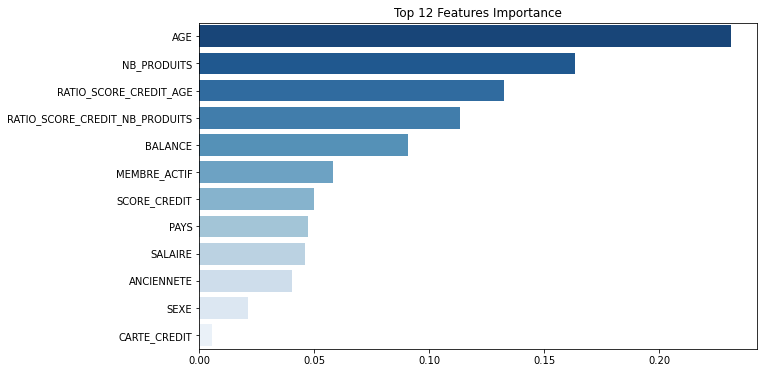

In [120]:
plot_features_importance(X_processed, importances=model['classifier'].feature_importances_, n_feat=12)

Random Forest found with bayesian search is slightly better in terms of best f2 score.

## 5. SVM

In [249]:
# Bayesian optimization. Takes up to 40 minutes, change n_calls to 10 and cv to 3 to speed up the process.

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, class_weight='balanced'))
])

space  = [Categorical([0, 350], name='preprocessor__CreditScoreImputer__value'),
          Real(10**-4, 10**3, "log-uniform", name='classifier__C'),
          Categorical(['poly', 'rbf'], name='classifier__kernel'),
          Integer(1, 4, name='classifier__degree')]
          
@use_named_args(space)
def objective(**params):
    model.set_params(**params)

    return -np.mean(cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, 
                                    scoring=f2_score))

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0, verbose=True)

print("Best score=%.4f" % -res_gp.fun)
print("""Best parameters:
- C=%.6f
- kernel=%s
- degree=%d""" % (res_gp.x[0], res_gp.x[1], res_gp.x[2]))

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 40.0948
Function value obtained: -0.6320
Current minimum: -0.6320
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 16.7218
Function value obtained: -0.6544
Current minimum: -0.6544
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 22.1785
Function value obtained: -0.6901
Current minimum: -0.6901
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 104.8707
Function value obtained: -0.6810
Current minimum: -0.6901
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 499.1614
Function value obtained: -0.6099
Current minimum: -0.6901
Iteration No: 6 st

TypeError: %d format: a number is required, not numpy.str_

In [250]:
print("""Best parameters:
- CreditScoreImputer=%d
- C=%.6f
- kernel=%s
- degree=%d""" % (res_gp.x[0], res_gp.x[1], res_gp.x[2], res_gp.x[3]))

Best parameters:
- CreditScoreImputer=0
- C=0.989159
- kernel=rbf
- degree=1


In [121]:
# Train model with parameters found with bayesian search.

prepro = Pipeline(steps=[
    ("DateTransformer", DateTransformer(**stg.PARAMS_DATE_TRANSFORMER)),
    ("CategoricalTypeTransformer", CategoricalTypeTransformer(**stg.PARAMS_CATEGORICAL_TYPE_TRANSFORMER)),
    ("BooleanEncoder", BooleanEncoder([SEXE, MEMBRE_ACTIF])),
    ("FrequencyEncoder", FrequencyEncoder([PAYS, CARTE_CREDIT])),
    ("AberrantAgeImputer", AberrantAgeImputer()),
    ("AberrantNbProduitsImputer", AberrantNbProduitsImputer()),
    ("CreditScoreImputer", CreditScoreImputer(0)),
    ("SalaryImputer", SalaryImputer(**stg.PARAMS_SALARY_IMPUTER)),
    ("BalanceImputer", BalanceImputer()),
    ("SeniorityCreator", SeniorityCreator(**stg.PARAMS_SENIORITY_CREATOR)),
    ("CreditScoreAgeRatioCreator", CreditScoreAgeRatioCreator(stg.RATIO_SCORE_CREDIT_AGE)),
    ("CreditScoreByNProductsCreator", CreditScoreByNProductsCreator(stg.RATIO_SCORE_CREDIT_NB_PRODUITS)),
    ("FeatureDropper", FeatureDropper(**stg.PARAMS_FEATURE_DROPPER))
])

model = Pipeline(steps=[
    ('prepro', prepro),
    ('scaler', StandardScaler()),
    ('classifier', SVC(C=0.989159,
                       kernel='rbf',
                       probability=True,
                       class_weight='balanced'))
])
model.fit(X_train, y_train)

Pipeline(steps=[('prepro',
                 Pipeline(steps=[('DateTransformer',
                                  DateTransformer(date_format='%Y-%m-%d '
                                                              '%H:%M:%S')),
                                 ('CategoricalTypeTransformer',
                                  CategoricalTypeTransformer(columns=['PAYS',
                                                                      'SEXE',
                                                                      'MEMBRE_ACTIF',
                                                                      'CARTE_CREDIT'])),
                                 ('BooleanEncoder',
                                  BooleanEncoder(columns=['SEXE',
                                                          'MEMBRE_ACTIF'])),
                                 ('FrequencyEncoder',
                                  FrequencyEncoder(columns=['PAYS',
                                                          

In [122]:
# Predict
y_proba = model.predict_proba(X_val)[:,1]
threshold,_ = find_threshold_f2(y_val, y_proba)

y_pred = (y_proba >= threshold).astype(bool)

In [123]:
#Save in dictionary
svm = {'model':model,
      'y_pred':y_pred,
      'y_proba':y_proba,
      'score':accuracy_score(y_val, y_pred),
      'recall':recall_score(y_val, y_pred),
      'ap':average_precision_score(y_val, y_proba),
      'fbeta_score':fbeta_score(y_val, y_pred, beta=2),
      'threshold': threshold
     }

In [124]:
#Score
print("model accuracy: %.2f" % accuracy_score(y_val, y_pred))
print("model recall: %.2f" % recall_score(y_val, y_pred))
print("model fbeta: %.2f" % fbeta_score(y_val, y_pred, beta=2))


print("\nPrecision-Recall-Fscore-Support")
print(precision_recall_fscore_support(y_val, y_pred, average='weighted'))

print("\nConfusion Matrix")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report")
print(classification_report(y_val, y_pred,
                            labels=[0,1],
                            target_names=['retain', 'churn']))

print("\nAverage Precision Score")
print(average_precision_score(y_val, y_proba))

model accuracy: 0.72
model recall: 0.85
model fbeta: 0.70

Precision-Recall-Fscore-Support
(0.8373340529404041, 0.7167085427135679, 0.7437867886092171, None)

Confusion Matrix
[[865 403]
 [ 48 276]]

Classification Report
              precision    recall  f1-score   support

      retain       0.95      0.68      0.79      1268
       churn       0.41      0.85      0.55       324

    accuracy                           0.72      1592
   macro avg       0.68      0.77      0.67      1592
weighted avg       0.84      0.72      0.74      1592


Average Precision Score
0.6538795285566049


## 6. KNN

In [125]:
#Model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('DateTransformer',
                                  DateTransformer(date_format='%Y-%m-%d '
                                                              '%H:%M:%S')),
                                 ('CategoricalTypeTransformer',
                                  CategoricalTypeTransformer(columns=['PAYS',
                                                                      'SEXE',
                                                                      'MEMBRE_ACTIF',
                                                                      'CARTE_CREDIT'])),
                                 ('BooleanEncoder',
                                  BooleanEncoder(columns=['SEXE',
                                                          'MEMBRE_ACTIF'])),
                                 ('FrequencyEncoder',
                                  FrequencyEncoder(columns=['PAYS'...
                                  SeniorityCreator

In [126]:
# Predict
y_proba = model.predict_proba(X_val)[:,1]
threshold,_ = find_threshold_f2(y_val, y_proba)

y_pred = (y_proba >= threshold).astype(bool)

In [127]:
#Save in dictionary
knn = {'model':model,
      'y_pred':y_pred,
      'y_proba':y_proba,
      'score':accuracy_score(y_val, y_pred),
      'recall':recall_score(y_val, y_pred),
      'ap':average_precision_score(y_val, y_proba),
      'fbeta_score':fbeta_score(y_val, y_pred, beta=2),
      'threshold': threshold
     }

In [128]:
#Score
print("model accuracy: %.2f" % accuracy_score(y_val, y_pred))
print("model recall: %.2f" % recall_score(y_val, y_pred))
print("model fbeta: %.2f" % fbeta_score(y_val, y_pred, beta=2))


print("\nPrecision-Recall-Fscore-Support")
print(precision_recall_fscore_support(y_val, y_pred, average='weighted'))

print("\nConfusion Matrix")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report")
print(classification_report(y_val, y_pred,
                            labels=[0,1],
                            target_names=['retain', 'churn']))

print("\nAverage Precision Score")
print(average_precision_score(y_val, y_proba))

model accuracy: 0.62
model recall: 0.80
model fbeta: 0.62

Precision-Recall-Fscore-Support
(0.7959091448289527, 0.6187185929648241, 0.6554176015434525, None)

Confusion Matrix
[[727 541]
 [ 66 258]]

Classification Report
              precision    recall  f1-score   support

      retain       0.92      0.57      0.71      1268
       churn       0.32      0.80      0.46       324

    accuracy                           0.62      1592
   macro avg       0.62      0.68      0.58      1592
weighted avg       0.80      0.62      0.66      1592


Average Precision Score
0.4822179654859429


## 7. XGBoost

In [215]:
# Bayesian optimization. Takes up to 15 minutes, change n_calls to 10 and cv to 3 to speed up the process.

preprocess = Pipeline(steps=[
    ("DateTransformer", DateTransformer(**stg.PARAMS_DATE_TRANSFORMER)),
    ("CategoricalTypeTransformer", CategoricalTypeTransformer(**stg.PARAMS_CATEGORICAL_TYPE_TRANSFORMER)),
    ("BooleanEncoder", BooleanEncoder([SEXE, MEMBRE_ACTIF, CARTE_CREDIT])),
    ("OneHotEncoder", CustomOneHotEncoder([PAYS])),
    ("AberrantAgeImputer", AberrantAgeImputer()),
    ("AberrantNbProduitsImputer", AberrantNbProduitsImputer()),
    ("CreditScoreImputer", CreditScoreImputer(**stg.PARAMS_CREDIT_SCORE_IMPUTER)),
    ("SalaryImputer", SalaryImputer(**stg.PARAMS_SALARY_IMPUTER)),
    ("BalanceImputer", BalanceImputer()),
    ("SeniorityCreator", SeniorityCreator(**stg.PARAMS_SENIORITY_CREATOR)),
    ("CreditScoreAgeRatioCreator", CreditScoreAgeRatioCreator(stg.RATIO_SCORE_CREDIT_AGE)),
    ("CreditScoreByNProductsCreator", CreditScoreByNProductsCreator(stg.RATIO_SCORE_CREDIT_NB_PRODUITS)),
    ("FeatureDropper", FeatureDropper(**stg.PARAMS_FEATURE_DROPPER))
])

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(scale_pos_weight=ratio))
])

space  = [Real(0.00001, 10, "log-uniform", name='classifier__learning_rate'),
          Integer(1, 5, name='classifier__max_depth'),
          Integer(10, 1500, name='classifier__n_estimators'),
          Real(0.5, 0.9, "uniform", name='classifier__subsample'),
          Real(0.2, 0.9, "uniform", name='classifier__colsample_bytree'),
          Real(10**-5, 10**2, "log-uniform", name='classifier__gamma'),
          Integer(1, 100, name='classifier__min_child_weight'),
          Real(10**-5, 10**2, "log-uniform", name='classifier__reg_lambda')]

@use_named_args(space)
def objective(**params):
    model.set_params(**params)

    return -np.mean(cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, 
                                    scoring=f2_score))

res_gp = gp_minimize(objective, space, n_calls=50, random_state=0, verbose=True)

print("Best score=%.4f" % -res_gp.fun)
print("""Best parameters:
- learning_rate=%.6f
- max_depth=%d
- n_estimators=%d
- subsample=%.3f
- colsample_bytree=%.3f
- gamma=%.6f
- min_child_weight=%d
- reg_lambda=%.6f""" % (res_gp.x[0], res_gp.x[1], res_gp.x[2], res_gp.x[3],
                              res_gp.x[4], res_gp.x[5], res_gp.x[6], res_gp.x[7]))

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 27.5108
Function value obtained: -0.6964
Current minimum: -0.6964
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 20.8259
Function value obtained: -0.6895
Current minimum: -0.6964
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.0919
Function value obtained: -0.6914
Current minimum: -0.6964
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 11.1848
Function value obtained: -0.6902
Current minimum: -0.6964
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 8.8044
Function value obtained: -0.6537
Current minimum: -0.6964
Iteration No: 6 start

In [129]:
# Train model with parameters found with bayesian search.
# It is not necessary to use a scaler for xgbclassifier, it was add for bayesian optimization which
# has a tendancy to crash when values are high.

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
preproc = Pipeline(steps=[
    ("DateTransformer", DateTransformer(**stg.PARAMS_DATE_TRANSFORMER)),
    ("BooleanEncoder", BooleanEncoder([SEXE, MEMBRE_ACTIF, CARTE_CREDIT])),
    ("OneHotEncoder", CustomOneHotEncoder([PAYS])),
    ("AberrantAgeImputer", AberrantAgeImputer()),
    ("AberrantNbProduitsImputer", AberrantNbProduitsImputer()),
    ("CreditScoreImputer", CreditScoreImputer(**stg.PARAMS_CREDIT_SCORE_IMPUTER)),
    ("SalaryImputer", SalaryImputer(**stg.PARAMS_SALARY_IMPUTER)),
    ("BalanceImputer", BalanceImputer()),
    ("SeniorityCreator", SeniorityCreator(**stg.PARAMS_SENIORITY_CREATOR)),
    ("CreditScoreAgeRatioCreator", CreditScoreAgeRatioCreator(stg.RATIO_SCORE_CREDIT_AGE)),
    ("CreditScoreByNProductsCreator", CreditScoreByNProductsCreator(stg.RATIO_SCORE_CREDIT_NB_PRODUITS)),
    ("FeatureDropper", FeatureDropper(**stg.PARAMS_FEATURE_DROPPER))
])

model = Pipeline(steps=[
    ('preproc', preproc),
    ('classifier', XGBClassifier(learning_rate=0.019804,
                                 max_depth=3,
                                 n_estimators=329,
                                 subsample=0.765,
                                 colsample_bytree=0.861,
                                 gamma=0.000010,
                                 min_child_weight=27,
                                 reg_lambda=0.003457,
                                 scale_pos_weight=ratio))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 Pipeline(steps=[('DateTransformer',
                                  DateTransformer(date_format='%Y-%m-%d '
                                                              '%H:%M:%S')),
                                 ('BooleanEncoder',
                                  BooleanEncoder(columns=['SEXE',
                                                          'MEMBRE_ACTIF',
                                                          'CARTE_CREDIT'])),
                                 ('OneHotEncoder',
                                  CustomOneHotEncoder(columns=['PAYS'])),
                                 ('AberrantAgeImputer', AberrantAgeImputer()),
                                 ('AberrantNbProduitsImputer',
                                  AberrantNbProduitsImputer(...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.019804, 

In [130]:
# Predict
y_proba = model.predict_proba(X_val)[:,1]
threshold,_ = find_threshold_f2(y_val, y_proba)

y_pred = (y_proba >= threshold).astype(bool)

In [131]:
#Save in dictionary
xgb = {'model':model,
      'y_pred':y_pred,
      'y_score':y_proba,
      'score':model.score(X_val, y_val),
      'recall':recall_score(y_val, y_pred),
      'ap':average_precision_score(y_val, y_proba),
      'fbeta_score':fbeta_score(y_val, y_pred, beta=2),
      'threshold': threshold
     }

In [132]:
#Score
print("model accuracy: %.3f" % accuracy_score(y_val, y_pred))
print("model recall: %.3f" % recall_score(y_val, y_pred))
print("model fbeta: %.3f" % fbeta_score(y_val, y_pred, beta=2))


print("\nPrecision-Recall-Fscore-Support")
print(precision_recall_fscore_support(y_val, y_pred, average='weighted'))

print("\nConfusion Matrix")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report")
print(classification_report(y_val, y_pred,
                            labels=[0,1],
                            target_names=['retain', 'churn']))

print("\nAverage Precision Score")
print(average_precision_score(y_val, y_proba))

model accuracy: 0.697
model recall: 0.892
model fbeta: 0.711

Precision-Recall-Fscore-Support
(0.8438297937779102, 0.6972361809045227, 0.7267110880415653, None)

Confusion Matrix
[[821 447]
 [ 35 289]]

Classification Report
              precision    recall  f1-score   support

      retain       0.96      0.65      0.77      1268
       churn       0.39      0.89      0.55       324

    accuracy                           0.70      1592
   macro avg       0.68      0.77      0.66      1592
weighted avg       0.84      0.70      0.73      1592


Average Precision Score
0.7042834029667974


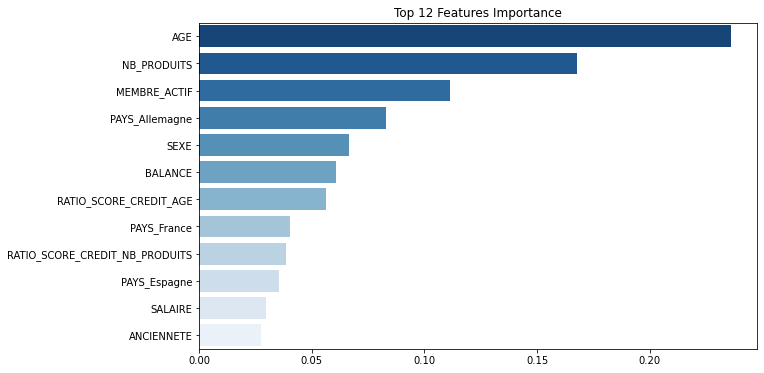

In [133]:
X_process = preproc.fit_transform(X, y)
plot_features_importance(X_process, importances=model['classifier'].feature_importances_, n_feat=12)

# Model choice

In [176]:
# Order result according to their best f2 score.
results = [lr, dt, rf, rf2, svm, knn, xgb]
sorted_results = sorted(results, key=lambda result: result['fbeta_score'], reverse=True)
best_result = sorted_results[0]
models = [result['model'] for result in sorted_results]

### Best model for f2 score

In [177]:
best_result['model'].fit(X_train, y_train)

# Predict
y_proba = best_result['model'].predict_proba(X_val)[:,1]
threshold,_ = find_threshold_f2(y_val, y_proba)

y_pred = (y_proba >= threshold).astype(bool)

In [179]:
#Score
print(f'classifier: {best_result["model"]["classifier"]}')
print("model accuracy: %.2f" % accuracy_score(y_val, y_pred))
print("model recall: %.2f" % recall_score(y_val, y_pred))
print("model fbeta: %.2f" % fbeta_score(y_val, y_pred, beta=2))


print("\nPrecision-Recall-Fscore-Support")
print(precision_recall_fscore_support(y_val, y_pred, average='weighted'))

print("\nConfusion Matrix")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report")
print(classification_report(y_val, y_pred,
                            labels=[0,1],
                            target_names=['retain', 'churn']))

print("\nAverage Precision Score")
print(average_precision_score(y_val, y_proba))

classifier: RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=8, min_samples_split=6, n_estimators=932,
                       random_state=40)
model accuracy: 0.71
model recall: 0.88
model fbeta: 0.71

Precision-Recall-Fscore-Support
(0.8446113569951421, 0.7116834170854272, 0.7395914073143742, None)

Confusion Matrix
[[847 421]
 [ 38 286]]

Classification Report
              precision    recall  f1-score   support

      retain       0.96      0.67      0.79      1268
       churn       0.40      0.88      0.55       324

    accuracy                           0.71      1592
   macro avg       0.68      0.78      0.67      1592
weighted avg       0.84      0.71      0.74      1592


Average Precision Score
0.6961312875653048


### Stacking attempt

In [312]:
# Bayesian optimization for meta classifier parameters.
# We take the four best estimators found.
# Takes up to 40 minutes with cv=3 and n_calls=30

log_reg = LogisticRegression(class_weight='balanced')

sclf = StackingCVClassifier(classifiers=models[:4],
                            meta_classifier=log_reg,
                            random_state=0)

space  = [Real(10**-4, 10**3, "log-uniform", name='meta_classifier__C')]

@use_named_args(space)
def objective(**params):
    sclf.set_params(**params)

    return -np.mean(cross_val_score(sclf, X_train, y_train, cv=3, n_jobs=-1, 
                                    scoring=f2_score))

res_gp = gp_minimize(objective, space, n_calls=30, random_state=0, verbose=True)

print("Best score=%.4f" % -res_gp.fun)
print("""Best parameters:
- metaclassifier_C=%.6f""" % (res_gp.x[0]))

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 58.8997
Function value obtained: -0.6891
Current minimum: -0.6891
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 56.3567
Function value obtained: -0.6888
Current minimum: -0.6891
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 58.2384
Function value obtained: -0.6891
Current minimum: -0.6891
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 60.3505
Function value obtained: -0.6891
Current minimum: -0.6891
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 59.0648
Function value obtained: -0.6894
Current minimum: -0.6894
Iteration No: 6 star

In [137]:
log_reg = LogisticRegression(class_weight='balanced',
                             C=62.981874)

model = StackingCVClassifier(classifiers=models[:4],
                            meta_classifier=log_reg, random_state=0)

model.fit(X_train, y_train)

StackingCVClassifier(classifiers=[Pipeline(steps=[('preproc',
                                                   Pipeline(steps=[('DateTransformer',
                                                                    DateTransformer(date_format='%Y-%m-%d '
                                                                                                '%H:%M:%S')),
                                                                   ('BooleanEncoder',
                                                                    BooleanEncoder(columns=['SEXE',
                                                                                            'MEMBRE_ACTIF',
                                                                                            'CARTE_CREDIT'])),
                                                                   ('OneHotEncoder',
                                                                    CustomOneHotEncoder(columns=['PAYS'])),
                                   

In [138]:
# Predict
y_proba = model.predict_proba(X_val)[:,1]
threshold,_ = find_threshold_f2(y_val, y_proba)
y_pred = (y_proba >= threshold).astype(bool)

In [139]:
# Save in dictionary
sclf = {'model':model,
      'y_pred':y_pred,
      'y_score':y_proba,
      'score':model.score(X_val, y_val),
      'recall':recall_score(y_val, y_pred),
      'ap':average_precision_score(y_val, y_proba),
      'fbeta_score':fbeta_score(y_val, y_pred, beta=2),
      'threshold': threshold
     }

In [140]:
# Score
print("model accuracy: %.2f" % accuracy_score(y_val, y_pred))
print("model recall: %.2f" % recall_score(y_val, y_pred))
print("model fbeta: %.2f" % fbeta_score(y_val, y_pred, beta=2))


print("\nPrecision-Recall-Fscore-Support")
print(precision_recall_fscore_support(y_val, y_pred, average='weighted'))

print("\nConfusion Matrix")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report")
print(classification_report(y_val, y_pred,
                            labels=[0,1],
                            target_names=['retain', 'churn']))

print("\nAverage Precision Score")
print(average_precision_score(y_val, y_proba))

model accuracy: 0.77
model recall: 0.80
model fbeta: 0.69

Precision-Recall-Fscore-Support
(0.8382302850821652, 0.7657035175879398, 0.7851595233027638, None)

Confusion Matrix
[[961 307]
 [ 66 258]]

Classification Report
              precision    recall  f1-score   support

      retain       0.94      0.76      0.84      1268
       churn       0.46      0.80      0.58       324

    accuracy                           0.77      1592
   macro avg       0.70      0.78      0.71      1592
weighted avg       0.84      0.77      0.79      1592


Average Precision Score
0.5752186638210685


Every model used in stacking give better results than stacking !

## Order models according to their best f2 score

In [180]:
results_stacking = results + [sclf]
sorted_results_stacking = sorted(results_stacking, key=lambda result: result['fbeta_score'], reverse=True)
models_stacking = [result['model'] for result in sorted_results_stacking]

In [181]:
for result in sorted_results_stacking:
    result['model'].fit(X_train, y_train)
    y_proba = result['model'].predict_proba(X_val)[:,1]
    y_pred = (y_proba >= result['threshold']).astype(bool)
    try:
        print(f'classifier: {result["model"]["classifier"]}')
    except TypeError:
        print('classifier: StackingCVClassifier')
    print("model recall: %.2f" % recall_score(y_val, y_pred))
    print("model fbeta: %.2f" % fbeta_score(y_val, y_pred, beta=2))
    print("model precision: %2f" % precision_score(y_val, y_pred))
    print("model accuracy: %.2f" % accuracy_score(y_val, y_pred))


    print("\nPrecision-Recall-Fscore-Support")
    print(precision_recall_fscore_support(y_val, y_pred, average='weighted'))

    print("\nConfusion Matrix")
    print(confusion_matrix(y_val, y_pred))

    print("\nClassification Report")
    print(classification_report(y_val, y_pred,
                                labels=[0,1],
                                target_names=['retain', 'churn']))

    print("\nAverage Precision Score")
    print(average_precision_score(y_val, y_proba))
    print("\n----------------------------------------------------\n")

classifier: RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=8, min_samples_split=6, n_estimators=932,
                       random_state=40)
model recall: 0.88
model fbeta: 0.71
model precision: 0.404526
model accuracy: 0.71

Precision-Recall-Fscore-Support
(0.8446113569951421, 0.7116834170854272, 0.7395914073143742, None)

Confusion Matrix
[[847 421]
 [ 38 286]]

Classification Report
              precision    recall  f1-score   support

      retain       0.96      0.67      0.79      1268
       churn       0.40      0.88      0.55       324

    accuracy                           0.71      1592
   macro avg       0.68      0.78      0.67      1592
weighted avg       0.84      0.71      0.74      1592


Average Precision Score
0.6961312875653048

----------------------------------------------------

classifier: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsa

### Plots

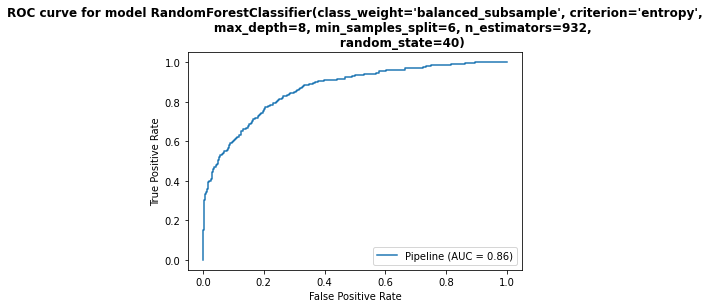

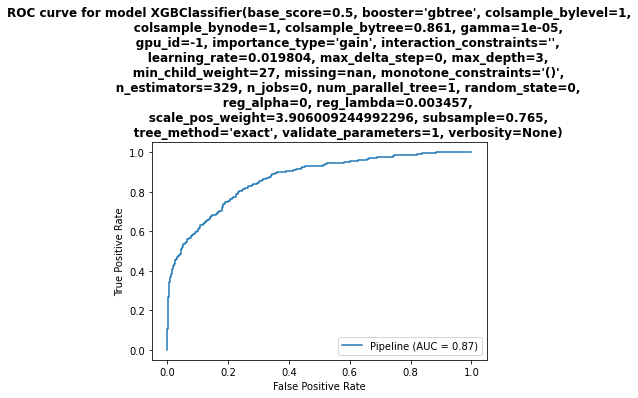

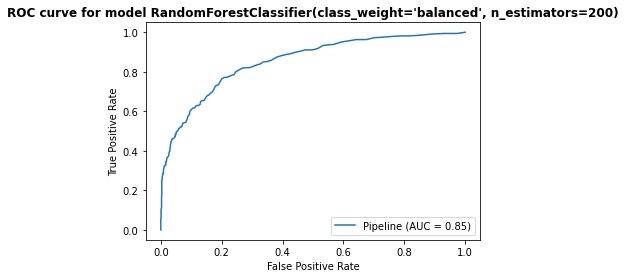

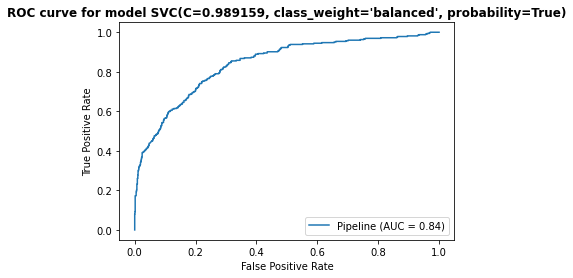

In [182]:
# ROC curves for the four best models
for model in models_stacking[:4]:
    plot_roc_curve(model, X_val, y_val)
    plt.title(f'ROC curve for model {model["classifier"]}', fontweight ="bold")

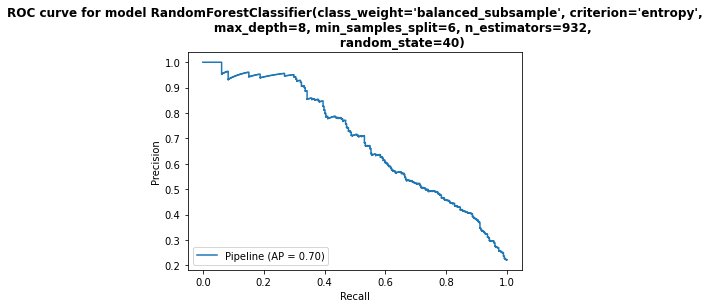

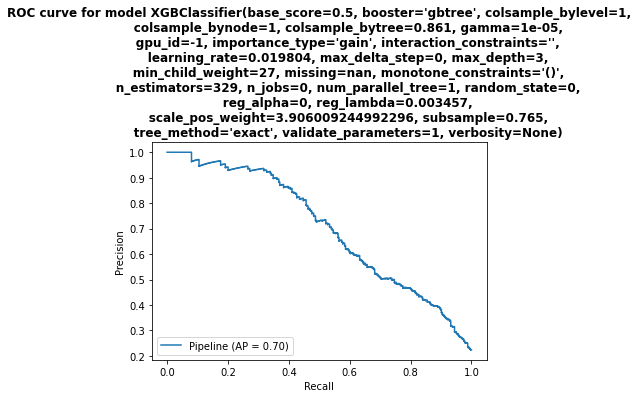

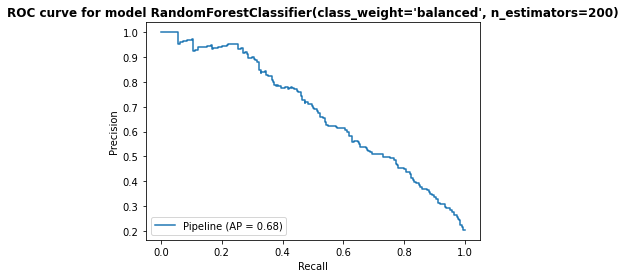

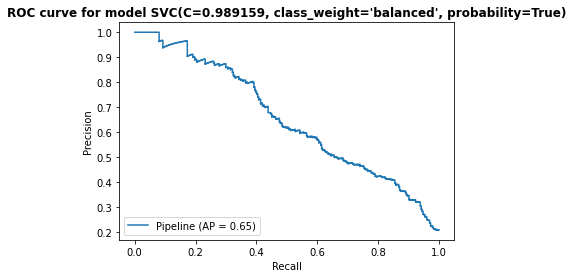

In [183]:
# Precision recall curves for the four best models
for model in models_stacking[:4]:
    plot_precision_recall_curve(model, X_val, y_val)
    plt.title(f'ROC curve for model {model["classifier"]}', fontweight ="bold")

## Evaluation of selected model

In [184]:
selected_result = sorted_results_stacking[0]
selected_model = selected_result['model'] 
selected_model.fit(X_dev, y_dev)

Pipeline(steps=[('prepro',
                 Pipeline(steps=[('DateTransformer',
                                  DateTransformer(date_format='%Y-%m-%d '
                                                              '%H:%M:%S')),
                                 ('CategoricalTypeTransformer',
                                  CategoricalTypeTransformer(columns=['PAYS',
                                                                      'SEXE',
                                                                      'MEMBRE_ACTIF',
                                                                      'CARTE_CREDIT'])),
                                 ('BooleanEncoder',
                                  BooleanEncoder(columns=['SEXE',
                                                          'MEMBRE_ACTIF'])),
                                 ('FrequencyEncoder',
                                  FrequencyEncoder(columns=['PAYS',
                                                          

In [185]:
y_proba = selected_model.predict_proba(X_test)[:,1]
y_pred = (y_proba >= selected_result['threshold']).astype(bool)

In [186]:
print("model recall: %.2f" % recall_score(y_test, y_pred))
print("model fbeta: %.2f" % fbeta_score(y_test, y_pred, beta=2))
print("model precision: %2f" % precision_score(y_test, y_pred))
print("model accuracy: %.2f" % accuracy_score(y_test, y_pred))

print("\nPrecision-Recall-Fscore-Support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

print("\nConfusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report")
print(classification_report(y_test, y_pred, labels=[0,1],
                            target_names=['retain', 'churn']))

print("\nAverage Precision Score")
print(average_precision_score(y_test, y_proba))

model recall: 0.88
model fbeta: 0.71
model precision: 0.395580
model accuracy: 0.70

Precision-Recall-Fscore-Support
(0.8424879188825458, 0.7015075376884422, 0.7305230156270675, None)

Confusion Matrix
[[1038  547]
 [  47  358]]

Classification Report
              precision    recall  f1-score   support

      retain       0.96      0.65      0.78      1585
       churn       0.40      0.88      0.55       405

    accuracy                           0.70      1990
   macro avg       0.68      0.77      0.66      1990
weighted avg       0.84      0.70      0.73      1990


Average Precision Score
0.6904472875140393


### Save best model

In [148]:
# Because you never know, save selected model with threshold to use
import pickle

model_to_use = {'pipeline': selected_model, 'threshold': selected_result['threshold']}

with open('model_to_use.pickle', 'wb') as handle:
    pickle.dump(model_to_use, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [187]:
with open('model_to_use.pickle', 'rb') as handle:
    model_saved = pickle.load(handle)

In [188]:
model_saved

{'pipeline': Pipeline(steps=[('prepro',
                  Pipeline(steps=[('DateTransformer',
                                   DateTransformer(date_format='%Y-%m-%d '
                                                               '%H:%M:%S')),
                                  ('CategoricalTypeTransformer',
                                   CategoricalTypeTransformer(columns=['PAYS',
                                                                       'SEXE',
                                                                       'MEMBRE_ACTIF',
                                                                       'CARTE_CREDIT'])),
                                  ('BooleanEncoder',
                                   BooleanEncoder(columns=['SEXE',
                                                           'MEMBRE_ACTIF'])),
                                  ('FrequencyEncoder',
                                   FrequencyEncoder(columns=['PAYS',
                                

In [ ]:
full_pipe = model_saved['pipeline']
preprocessing_to_use = full_pipe['prepro']
classifier_to_use = full_pipe['classifier']
threshold_to_use = model_saved['threshold']